xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# Final Capstone Project

## Weather Forecasting using Machine Learning

#### submitted by:
### Saeed Manavipour

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

###   Overview


In this project, weather is predicted for different cities using machine learning algorithms. 
The data was collected from the website Kaggle. It consists of five years (from October 2012 to October 2017) of hourly data of temperature, pressure, humidity, wind speed, wind direction for 30 cities in North America and 6 cities in Israel (each 45000 rows). 

It also contains geographical coordinates such as latitude and longitude of all the cities and hourly weather description (sunny, rainy, snowy …). Other features such as elevation and season were added later on.

The units of measurements in this study were given careful consideration and were converted whenever needed to be used in formulas and functions. For example in the csv files, temperature is reported in kelvin (K) but in the output of the study is shown in degree Celsius (C).

At the end of this notebook, the Appendix section gives additional information on exploratory data Analysis (EDA), hyper-parameter optimization and any other extra work that was done during this project.

###   Importing all the necessary libraries




In [ ]:
import os
import time
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from plotly.plotly import plot_mpl
import pandas as pd
import statistics as stat
from collections import Counter
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, metrics, linear_model,neighbors, tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

###   Reading and importing all the csv files


The csv files used in this project are as follows:

df_attributes contains the name of each city(36 in total), country, geographical coordinates(longitude, latitude). Also later on, elevation and whether or not the city is a coastal one (by_the_water) were added as new columns/features.

df_temp contains temperature(K) for each city at each hour.

df_pressure contains pressure(mili bar) for each city at each hour.

df_humidity contains relative humidity(%) for each city at each hour.

df_wind contains wind speed(m/s) for each city at each hour.

df_wdir contains wind direction in degrees(0-360) for each city at each hour.

df_desc contains weather description for each city at each hour. The descriptions are in string form such as 'sky is clear' or 'light rain', etc. These descriptions will be converted into categorical classes later on.

Then at the end, all NAN values for df_desc are dropped.

In [3]:
my_path='C:\\Users\\saeed\\Downloads\\notebook\\weather data\\'
df_attributes = pd.read_csv(my_path+"city_attributes.csv")
df_temp = pd.read_csv(my_path+"temperature.csv",parse_dates=['datetime'],index_col='datetime')
df_pressure = pd.read_csv(my_path+"pressure.csv",parse_dates=['datetime'],index_col='datetime')
df_humidity = pd.read_csv(my_path+"humidity.csv",parse_dates=['datetime'],index_col='datetime')
df_wind = pd.read_csv(my_path+"wind_speed.csv",parse_dates=['datetime'],index_col='datetime')
df_wdir = pd.read_csv(my_path+"wind_direction.csv",parse_dates=['datetime'],index_col='datetime')
df_desc = pd.read_csv(my_path+"weather_description.csv",parse_dates=['datetime'],index_col='datetime')
cities=df_attributes['City']
df_attributes.set_index('City',inplace=True)
df_desc.dropna(how='any',inplace=True)

###   Functions


In the following cell, all functions are defined:

get_season returns the season (0-3) given month as input, where 0 is winter, 1 is spring, 2 is fall and 3 is summer.

get_direction takes wind direction as input in degrees (0-360) and returns one of 8 classes (0-7), where: 0 is North, 1 is Northeast, 2 is East, 3 is Southeast, 4 is South, 5 is Southwest, 6 is West and 7 is Northwest.

get_windchill takes temperature(C) and wind speed (m/s) as input and returns the wind chill temperature (feels like temperature). The formula was taken from weather.gov and it is only valid if temperature(F) is less than 50 and wind(mph) is bigger than 3 (in other words, the function only returns a value if its too cold and too windy).

get_heatindex takes temperature(C) and relative humidity(%) as input and returns the heat index temperature (feels like temperature). The formula was taken from weather.gov and it is only valid if temperature(C) is above 26.7 (in other words, the function only returns a value if it’s too hot).

get_predictions takes today as a date(year-month-day) and city code (0-35) to show and print out prediction results for weather for that city on that date. The function can be used in loops for multiple days and cities.

In [4]:
def get_season(input_month):
    my_season=0
    if input_month in [3,4,5]:
        my_season=1
    elif input_month in [9,10,11]:
        my_season=2                   
    elif input_month in [6,7,8]:
        my_season=3          
    return my_season 

### redefining win direction based on category(0-7)(N to NW)
winddir_desc={0:'N',1:'NE',2:'E',3:'SE',4:'S',5:'SW',6:'W',7:'NW'}
def get_direction(input_dir):
    my_direction=0    
    if input_dir >= 23 and input_dir < 68 :  
        my_direction=1
    elif input_dir >= 68 and input_dir < 112 :  
        my_direction=2
    elif input_dir >= 112 and input_dir < 157 :  
        my_direction=3
    elif input_dir >= 157 and input_dir < 202 :  
        my_direction=4        
    elif input_dir >= 202 and input_dir < 247 :  
        my_direction=5
    elif input_dir >= 247 and input_dir < 292 :  
        my_direction=6
    elif input_dir >= 292 and input_dir < 337 :  
        my_direction=7        
    return my_direction 


### wind chill calculator:
##The wind chill calculator only works 
##for temperatures  below 50 ° F and wind speeds above 3 mph.
def get_windchill(T_c,wind_m_s):        
    T_fr=(9/5*T_c)+32
    # wind_km_hr=13
    # Windmph = 0.621371*wind_km_hr    
    Windmph = 2.23694*wind_m_s
    windchill=35.74+(0.6215*T_fr)-(35.75*(Windmph**0.16))+(0.4275*T_fr*(Windmph**0.16))
    windchill=round((windchill-32)*(5/9))
    if (T_fr<50) &(Windmph>3):
        print('Feels Like:     ',windchill,' C') 
    return

### Heat Index calculator:
## A heat index value cannot be calculated for temperatures less than 26.7 degrees Celsius
def get_heatindex(T_c,rh):        
    T_fr=(9/5*T_c)+32
    heatindex = -42.379 + (2.04901523*T_fr) + (10.14333127*rh) - (.22475541*T_fr*rh) - (.00683783*T_fr*T_fr) - (.05481717*rh*rh) 
    heatindex =heatindex + (.00122874*T_fr*T_fr*rh) + (.00085282*T_fr*rh*rh) - (.00000199*T_fr*T_fr*rh*rh)
    heatindex=round((heatindex-32)*(5/9))
    if (T_c>26.7): 
        print('Feels Like:     ',heatindex,' C')
    return


### show predictions and print results
def get_predictions(today,code):    
    nreg_variables=len(x_reg)
    my_data=[]
    for i in range(nreg_variables):
        my_data.append(df_city[code].loc[today,x_reg[i]])
    data1=[my_data]
    data2=np.array(data1)
    print('****************************************************************')
    print('****************************************************************')    
    print('\033[1m' +cities[code],', ',today)
    print('\033[m''*******************************')
    prediction_temp = lin_reg_temp.predict(data1)
    prediction_press = lin_reg_pressure.predict(data1)   
    prediction_hum = lin_reg_humidity.predict(data1)    
    prediction_wind = lin_reg_wind.predict(data1)     
    print('Temperature:    ',round(prediction_temp[0]-273.15,2),'C' )
    print('Pressure:       ',round(0.1*prediction_press[0],2),'kPa' )
    print('Humidity:       ',round(prediction_hum[0],2),'%' )
    print('Wind Speed:     ',round(prediction_wind[0],2),'m/s' )    
    
    n_variables=len(xs)
    my_data=[]
    for i in range(n_variables-3):
        my_data.append(df_city[code].loc[today,xs[i]])
    my_data.append(prediction_temp[0])
    my_data.append(prediction_press[0])
    my_data.append(prediction_hum[0])
    data1=[my_data]
    data2=np.array(data1)
    prediction = XGB_winddir.predict(data1)
    print('Wind Direction: ', winddir_desc[prediction[0]])
    get_windchill(prediction_temp[0]-273.15,prediction_wind[0])
    get_heatindex(prediction_temp[0]-273.15,prediction_hum[0])
    print()
    prediction = XGB_status.predict(data1)
    main_prediction=prediction[0]    
    my_probablity = XGB_status.predict_proba(data1)
    
    second_bool=False
    for i in range(6):    
        num1=round(100*(my_probablity[0][i]),1)
        if (num1>30) & (int(prediction[0])!=i):
            second_bool=True
            second_prediction=i
    print('\033[1m' + 'Weather Forcast:')
    print('\033[m''Mostly', description[main_prediction])
    if second_bool:
        print('Partly', description[second_prediction])
    print('Probability of Precipitation (PoP):  %',int(round(100*(my_probablity[0][3]))))
    ## showing weather icon
    image_name=''
    image_name='image_'+str(int(main_prediction))
    if second_bool:
        image_name=image_name+str(int(second_prediction))  
    image_name=image_name+'.png'
    plt.rcParams['figure.figsize']=(1.5,1.5)
    img=mpimg.imread(image_name);
    imgplot = plt.imshow(img);
    plt.axis('off')
    plt.show();
    return 

### Redefining the data frame df_desc


In the following cell, we are replacing the string values in df_desc (weather description) with 6 integer numbers (0-5), where 0 means sunny, 1 means cloudy, 2 means foggy, 3 means rainy, 4 means snowy and 5 means stormy.

In [5]:
description={0:'Sunny',1:'Cloudy',2:'Foggy',3:'Rainy',4:'Snowy',5:'Storm'}

###    sunny weather :0
df_desc.replace('sky is clear',0,inplace=True);
###    cloudy weather :1
cloudy_stauts=['few clouds','scattered clouds','broken clouds','overcast clouds']
df_desc.replace(cloudy_stauts,1,inplace=True);
###    foggy weather :2
foggy_stauts=['mist','haze','smoke','fog','dust', 'sand', 'volcanic ash' 
             ,'proximity sand/dust whirls','sand/dust whirls']
df_desc.replace(foggy_stauts,2,inplace=True);
###    rainy weather :3
rainy_stauts=['very heavy rain','heavy intensity rain','moderate rain','light rain',
'light intensity shower rain','shower rain','heavy intensity shower rain',
'light shower sleet','light rain and snow','shower drizzle','ragged shower rain',              
'heavy intensity drizzle','drizzle','light intensity drizzle','proximity shower rain',
'freezing rain','sleet','light intensity drizzle rain' , 'proximity moderate rain']                            
df_desc.replace(rainy_stauts,3,inplace=True);
###    snowy weather :4
snow_stauts=['heavy snow','light snow','light shower snow','snow','shower snow',
             'heavy shower snow','rain and snow']
df_desc.replace(snow_stauts,4,inplace=True);
###    stormy weather :5
storm_stauts=['thunderstorm with rain','thunderstorm with heavy rain',
'thunderstorm with light rain','proximity thunderstorm','proximity thunderstorm with rain','thunderstorm with light drizzle',
'thunderstorm with drizzle','ragged thunderstorm','proximity thunderstorm with drizzle'
,'heavy thunderstorm' ,'thunderstorm with heavy drizzle','squalls','tornado','thunderstorm']

df_desc.replace(storm_stauts,5,inplace=True);

###   Loading the data for each city


In the next cell, all the data is loaded separately for each city in a data frame called df_city[code], where code is the index of that city (0-35). Each city will have its own columns for features such as temperature, pressure, longitude etc.

A new column named 'status' is created which takes the mode of all the weather description of that day (eg. if a day was 20 hours sunny and 4 hours cloudy, its status will be 0 meaning sunny)

Then the data is converted from hourly to daily.

Then, rows with infinite values are located and dropped.

New columns are created to contain the data of past two days (eg. status_1 means weather description of yesterday and temp_2 means temperature of 2 days ago). These columns will be our independent variables to predict the weather for today.

After each city is loaded, the code will print out the city's name and index. It will take around 20 minutes to run this cell and load all the cities.

In [6]:
df_city=list(range(len(cities)))

start_time = time.time()
for code in range(0,36):
    city=cities[code]
    df = pd.DataFrame(index=df_temp.index)
    df['temp']=df_temp[city]
    df['pressure']=df_pressure[city]
    df['humidity']=df_humidity[city]
    df['wind']=df_wind[city]
    df['wind_dir']=df_wdir[city]
    df['desc']=df_desc[city]
    df.replace([np.inf, -np.inf], 0,inplace = True)
    df.dropna(how='any',inplace=True)
    status_mode=[]
    start_date='2012-10-01'
    end_date='2017-10-28'    
    ##Note: vancouver(35) does not start from october 01, so it needs special treatment 
    if code==35:
        start_date='2012-10-02'    
    ## defining status as the mode of that day:      
    days=pd.date_range(start=start_date, end=end_date,dtype='datetime64[ns]', freq='D')
    for day in days:
        ddd=day.strftime('%Y-%m-%d')
        my_status=(df.desc[ddd])
        list1=list(my_status)
        try:
            my_mode=stat.mode(list1)
        except:
            my_mode=1    
        status_mode.append(my_mode)
   
    df['status']=df['desc']
    df['Longitude']=df_attributes['Longitude'][code]
    df['Latitude']=df_attributes['Latitude'][code]
    df['Elevation']=df_attributes['Elevation'][code]
    df['by_the_water']=df_attributes['by_the_water'][code]   
    
#   converting the hourly data to daily format 
    df=pd.DataFrame(df.resample('D').mean())

    df['status']=status_mode
    del df['desc']   
    df['month']=(df.index).month
    n_rows = df.shape[0]
    df['season']=0
    
    for i in range(0,n_rows):
        my_month=(df.ix[i,'month'])
        df.ix[i,'season']=get_season(my_month)
        df.ix[i,'wind_dir']=get_direction(df.ix[i,'wind_dir'])
#   dropping infinite values             
    index_inf=[]
    n_rows = df.shape[0]
    for i in range(1,n_rows):
        bool_inf=not (np.isfinite(df.iloc[i,2]))
        if bool_inf:
            index_inf.append(i)
    df.drop(df.index[index_inf],inplace=True)

    ### creating new features from one and two last time days:
    n_rows = df.shape[0]
    for i in range(2,n_rows):
        df.ix[i,'temp_1']=df.ix[i-1,'temp']    
        df.ix[i,'temp_2']=df.ix[i-2,'temp'] 
        df.ix[i,'pressure_1']=df.ix[i-1,'pressure']    
        df.ix[i,'pressure_2']=df.ix[i-2,'pressure'] 
        df.ix[i,'humidity_1']=df.ix[i-1,'humidity']    
        df.ix[i,'humidity_2']=df.ix[i-2,'humidity']     
        df.ix[i,'wind_1']=df.ix[i-1,'wind']    
        df.ix[i,'wind_2']=df.ix[i-2,'wind']     
        df.ix[i,'wind_dir_1']=df.ix[i-1,'wind_dir']    
        df.ix[i,'wind_dir_2']=df.ix[i-2,'wind_dir']         
        df.ix[i,'status_1']=df.ix[i-1,'status']    
        df.ix[i,'status_2']=df.ix[i-2,'status']

    ### removing first two rows cuz they have lots of 0's (october 1 and 2 of 2012 are removed)
    df.drop(df.index[0],inplace=True)
    df.drop(df.index[0],inplace=True)  
    df_city[code]=df.copy()
    print(code, city,' Loaded')
print("--- %s seconds ---" % (time.time() - start_time))

0 Albuquerque  Loaded
1 Atlanta  Loaded
2 Beersheba  Loaded
3 Boston  Loaded
4 Charlotte  Loaded
5 Chicago  Loaded
6 Dallas  Loaded
7 Denver  Loaded
8 Detroit  Loaded
9 Eilat  Loaded
10 Haifa  Loaded
11 Houston  Loaded
12 Indianapolis  Loaded
13 Jacksonville  Loaded
14 Jerusalem  Loaded
15 Kansas City  Loaded
16 Las Vegas  Loaded
17 Los Angeles  Loaded
18 Miami  Loaded
19 Minneapolis  Loaded
20 Montreal  Loaded
21 Nahariyya  Loaded
22 Nashville  Loaded
23 New York  Loaded
24 Philadelphia  Loaded
25 Phoenix  Loaded
26 Pittsburgh  Loaded
27 Portland  Loaded
28 Saint Louis  Loaded
29 San Antonio  Loaded
30 San Diego  Loaded
31 San Francisco  Loaded
32 Seattle  Loaded
33 Tel Aviv District  Loaded
34 Toronto  Loaded
35 Vancouver  Loaded
--- 1166.6411881446838 seconds ---


###   Concating all the data frames together


Here, all the cities are combined together using  pd.concat creating a big data frame with 66k rows.We will use this data frame (df_concat) to train and test our models.

In [7]:
df_concat=pd.concat([df_city[i] for i in range(0,36)])
print('df_concat shape: ',df_concat.shape)
df_concat.head()

df_concat shape:  (66601, 24)


,temp,pressure,humidity,wind,wind_dir,status,Longitude,Latitude,Elevation,by_the_water,...,pressure_1,pressure_2,humidity_1,humidity_2,wind_1,wind_2,wind_dir_1,wind_dir_2,status_1,status_2
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-03,291.923333,1021.666667,31.904762,3.333333,3.0,0.0,-106.651138,35.084492,1619.0,0.0,...,1022.772727,1024.000000,40.363636,48.909091,3.272727,4.000000,7.0,0.0,0.0,0.0
2012-10-04,293.578636,1018.318182,19.681818,1.954545,3.0,1.0,-106.651138,35.084492,1619.0,0.0,...,1021.666667,1022.772727,31.904762,40.363636,3.333333,3.272727,3.0,7.0,0.0,0.0
2012-10-05,291.827500,1020.850000,18.250000,2.550000,5.0,0.0,-106.651138,35.084492,1619.0,0.0,...,1018.318182,1021.666667,19.681818,31.904762,1.954545,3.333333,3.0,3.0,1.0,0.0
2012-10-06,293.471905,1020.190476,19.238095,3.761905,5.0,1.0,-106.651138,35.084492,1619.0,0.0,...,1020.850000,1018.318182,18.250000,19.681818,2.550000,1.954545,5.0,3.0,0.0,1.0
2012-10-07,288.791522,1002.695652,29.695652,2.260870,4.0,1.0,-106.651138,35.084492,1619.0,0.0,...,1020.190476,1020.850000,19.238095,18.250000,3.761905,2.550000,5.0,5.0,1.0,0.0


In the next cell, looking at df_concat, we can see the most correlated features for each variable. For example for status, most correlated features are status of yesterday and today's humidity.

In [8]:
df_cor=abs(df_concat.corr())
# var1='wind_dir'
var1='status'
# var1='by_the_water'
# var1='temp'
# var1='humidity'
# var1='season'
# var1='month'

predictors= df_cor[var1].sort_values(ascending=False)
predictors.head(6)

by_the_water    1.000000
Elevation       0.453382
humidity        0.283140
humidity_1      0.283049
humidity_2      0.282925
Latitude        0.119630
Name: by_the_water, dtype: float64

###   Linear Regression for continuous variables


In the next cell, we are training Linear Regression models for continuous target variables (temperature, pressure, humidity, wind speed). First, the data is split into train and test set, then the models are trained and then tested on test set. Then accuracy score for each model is printed out. As seen here the model produces good results specially for temperature. 

In [9]:
x_reg=['temp_1','temp_2','pressure_1','pressure_2','humidity_1','humidity_2','wind_1',
       'by_the_water' ,'wind_2' , 'month', 'status_1', 'status_2','Longitude','Latitude',
       'Elevation','season']
nreg_variables=len(x_reg)
x = df_concat[x_reg].values
y = df_concat['temp'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 
lin_reg_temp = linear_model.LinearRegression()
lin_reg_temp.fit(x,y);

print('Linear Regression temperature Score: %',round(100*lin_reg_temp.score(x_test,y_test),2)) 
y = df_concat['pressure'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 
lin_reg_pressure = linear_model.LinearRegression()
lin_reg_pressure.fit(x,y); 
print('Linear Regression pressure Score:    %',round(100*lin_reg_pressure.score(x_test,y_test),2)) 

y = df_concat['humidity'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 
lin_reg_humidity = linear_model.LinearRegression()
lin_reg_humidity.fit(x,y); 
print('Linear Regression humidity Score:    %',round(100*lin_reg_humidity.score(x_test,y_test),2))

y = df_concat['wind'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 
lin_reg_wind = linear_model.LinearRegression()
lin_reg_wind.fit(x,y); 
print('Linear Regression wind Score:        %',round(100*lin_reg_wind.score(x_test,y_test),2))

Linear Regression temperature Score: % 92.97
Linear Regression pressure Score:    % 73.79
Linear Regression humidity Score:    % 69.99
Linear Regression wind Score:        % 40.06


###   Classification models for weather status


In the next cells, we are using different classification models to predict the categorical target variable 'status' (weather description of the day). 

Note: the last three dependent variables used as input here are temperature, pressure and humidity of that day. These features are used to train and test the model only. Later on when we are predicting the weather status, these three input variables are taken from prediction of our previous linear regression models. In other words, for a given day and city, the model first predicts temperature, pressure and humidity using linear regression and then uses those predictions to predict the status of that day.

At the first step, we look at baseline score, using dummy classifier. The score we get is 41%, meaning that we need to train a classification model that does better than that.

In [10]:
xs=['temp_1','temp_2','pressure_1','pressure_2','humidity_1','humidity_2','wind_1' 
    ,'wind_2' , 'status_1', 'status_2','wind_dir_1','wind_dir_2','Longitude','Latitude',
    'Elevation' ,'month','by_the_water','season',
    'temp','pressure', 'humidity']

x = df_concat[xs].values
y = df_concat['status'].values

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y)
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit( x_train,y_train )
print("Baseline status score: %" , round(100 * dummy_classifier.score(x_test,y_test),2))

Baseline status score: % 41.04


Next we train and test a variety of different classification models to see which one gives us the best results:

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### fitting Logistic Regression model:
my_regression = LogisticRegression(C=1.0,solver='lbfgs')
my_regression.fit(x_train,y_train)
print("Logistic Regression: %" , round(100 * my_regression.score(x_test,y_test),2))

### fitting K nearest neighbor model:
KNN_model = neighbors.KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(x_train,y_train)
print("KNN model:           %" , round(100 * KNN_model.score(x_test,y_test),2))

### fitting decision tree model:
DT_model = tree.DecisionTreeClassifier(max_depth=7)
DT_model.fit(x_train,y_train)
print("Decision Tree model: %" , round(100 * DT_model.score(x_test,y_test),2))

my_random_forest = RandomForestClassifier(n_estimators=300,max_depth=50,oob_score=True)
my_random_forest.fit(x_train,y_train)
print("Random Forest:       %" , round(100 * my_random_forest.score(x_test,y_test),2))

NN_model = MLPClassifier(hidden_layer_sizes=(10,10,10))
NN_model.fit(x_train,y_train)
print("Neural Network:      %" , round(100 * NN_model.score(x_test,y_test),2))

XGB_Model = XGBClassifier(max_depth=7,booster='gbtree')
XGB_Model.fit(x_train,y_train)
print("XG-Boost:            %" , round(100 * XGB_Model.score(x_test,y_test),2))

Logistic Regression: % 58.54
KNN model:           % 60.74
Decision Tree model: % 62.34
Random Forest:       % 67.06
Neural Network:      % 64.51
XG-Boost:            % 66.75


The highest scores we get are around %67. We choose XG-Boost to move forward.

Since our data is imbalanced (sunny and cloudy days are dominant classes and stormy is a rare class), we use SMOTE (Synthetic Minority Over-sampling Technique) to oversample our target column with the rare class. As a result, in the final y_train, all classes will be equal in number.

Training and testing XGBoost model, we get the score of %65 which is an improvement compared to baseline score.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,stratify=y)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

XGB_status = XGBClassifier(max_depth=7,booster='gbtree')
sm = SMOTE()
x_smote, y_smote = sm.fit_sample(x_train,y_train)
XGB_status.fit(x_smote, y_smote);
print("SMOTE XG Boost status score: %" , round(100 * XGB_status.score(x_test,y_test),2))

SMOTE XG Boost status score: % 65.16


### Confusion matrix for weather status


In the next cell we create confusion matrix for our XGBoost model. To make it easier to read, the matrix is formed into a nice data frame where total number of each class and their corresponding accuracy score is shown as well. 

As seen below, the model managed to get a score of %64 for snowy days even when there were only 198 snowy days on our y_test.

In [13]:
confusion = confusion_matrix(y_test, XGB_status.predict(x_test))
total_list=[]
list1=list(y_test)
for i in range(6):
    total_list.append(list1.count(i))
df_confusion=pd.DataFrame(confusion)
df_confusion['Total']=total_list
df_confusion['Sc']=total_list
df_confusion['Class']=total_list
for i in range(6):
    my_score=round(100*(df_confusion.ix[i,i])/df_confusion.ix[i,'Total'],1)
    df_confusion.ix[i,'Sc']='% '+str(int(my_score))
    df_confusion.ix[i,'Class']=description[i]
    df_confusion[description[i]]=df_confusion[i]
    del df_confusion[i]
del df_confusion['Total']
df_confusion['Total']=total_list
df_confusion['Score']=df_confusion['Sc']
del df_confusion['Sc']
df_confusion=df_confusion.set_index('Class')
df_confusion

,Sunny,Cloudy,Foggy,Rainy,Snowy,Storm,Total,Score
Class,,,,,,,,
Sunny,5931,1781,198,194,67,2,8173,% 72
Cloudy,1835,5045,608,574,117,21,8200,% 61
Foggy,123,306,866,137,13,4,1449,% 59
Rainy,172,490,195,1073,14,4,1948,% 55
Snowy,17,64,11,5,104,0,201,% 51
Storm,2,7,0,0,0,1,10,% 10


The following cell will print out total number of each class in our df_concat data frame:

In [14]:
###  total number of days for each status  in df_concat
list1=list(df_concat['status'])
for i in range(6):
    print(description[i],':',list1.count(i))
print('Total:' ,df_concat.shape[0])

Sunny : 27242
Cloudy : 27333
Foggy : 4830
Rainy : 6491
Snowy : 671
Storm : 34
Total: 66601


In the next cell, we use XGBoost for classification of weather direction. 
We get a score of %40 which is still better than the baseline of %24. 

In [15]:
###                      classification for wind direction
x = df_concat[xs].values
y = df_concat['wind_dir'].values

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y)
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit( x_train,y_train )
print("Baseline wind direction score: %" , round(100 * dummy_classifier.score(x_test,y_test),2))

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
XGB_winddir = XGBClassifier(max_depth=7,booster='gbtree')
XGB_winddir.fit(x_train,y_train)
print("XG Boost wind direction score: %" , round(100 * XGB_winddir.score(x_test,y_test),2))

Baseline wind direction score: % 24.88
XG Boost wind direction score: % 39.54


### Predictions & sample results


The following cell, uses the function get_predictions to print out weather prediction for a given day and city. The function will print out the name of the city and the date and weather prediction of temperature(C), pressure(kPa), humidity(%), wind speed (m/s), wind direction and feels like temperature (if applicable).

The weather forecast (status) is based on the most probable classification of XGBoost model (main_prediction) and it is printed after the word "Mostly". 

Then the second most probable description (second_prediction) is reported as "Partly" (This description will only be reported if probability is above %30).

Next, Probability of Precipitation (PoP) will be printed out which is basically probability of that day being classified as a rainy day (status=3)

At the end, based on the main_prediction and second_prediction (if applicable), the function will show a small nice weather icon describing the weather description of that day.

As an example, in the following cell, for the city of Toronto (code=34) for a few days of February 2013 all weather predictions are shown: 


****************************************************************
****************************************************************
Toronto ,  2013-02-01 00:00:00
*******************************
Temperature:     6.71 C
Pressure:        99.99 kPa
Humidity:        91.47 %
Wind Speed:      3.44 m/s
Wind Direction:  SW
Feels Like:      4.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 14


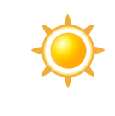

****************************************************************
****************************************************************
Toronto ,  2013-02-02 00:00:00
*******************************
Temperature:     -5.0 C
Pressure:        100.42 kPa
Humidity:        68.9 %
Wind Speed:      6.5 m/s
Wind Direction:  SW
Feels Like:      -12.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 15


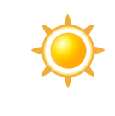

****************************************************************
****************************************************************
Toronto ,  2013-02-03 00:00:00
*******************************
Temperature:     -4.71 C
Pressure:        101.7 kPa
Humidity:        64.46 %
Wind Speed:      5.81 m/s
Wind Direction:  SW
Feels Like:      -11.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 21


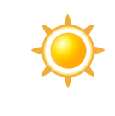

****************************************************************
****************************************************************
Toronto ,  2013-02-04 00:00:00
*******************************
Temperature:     -6.88 C
Pressure:        102.08 kPa
Humidity:        74.75 %
Wind Speed:      6.02 m/s
Wind Direction:  SW
Feels Like:      -14.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 22


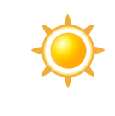

****************************************************************
****************************************************************
Toronto ,  2013-02-05 00:00:00
*******************************
Temperature:     -4.06 C
Pressure:        101.23 kPa
Humidity:        75.94 %
Wind Speed:      3.58 m/s
Wind Direction:  SW
Feels Like:      -9.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 17


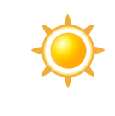

****************************************************************
****************************************************************
Toronto ,  2013-02-06 00:00:00
*******************************
Temperature:     -6.79 C
Pressure:        101.62 kPa
Humidity:        69.9 %
Wind Speed:      5.0 m/s
Wind Direction:  SW
Feels Like:      -13.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 25


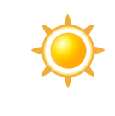

****************************************************************
****************************************************************
Toronto ,  2013-02-07 00:00:00
*******************************
Temperature:     -4.22 C
Pressure:        101.26 kPa
Humidity:        71.75 %
Wind Speed:      3.12 m/s
Wind Direction:  SW
Feels Like:      -9.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 17


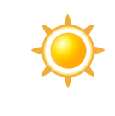

****************************************************************
****************************************************************
Toronto ,  2013-02-08 00:00:00
*******************************
Temperature:     -4.57 C
Pressure:        101.94 kPa
Humidity:        65.57 %
Wind Speed:      4.44 m/s
Wind Direction:  SE
Feels Like:      -10.0  C

Weather Forcast:
Mostly Cloudy
Partly Sunny
Probability of Precipitation (PoP):  % 14


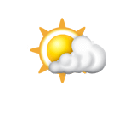

****************************************************************
****************************************************************
Toronto ,  2013-02-09 00:00:00
*******************************
Temperature:     -3.16 C
Pressure:        102.62 kPa
Humidity:        75.48 %
Wind Speed:      5.25 m/s
Wind Direction:  SW
Feels Like:      -9.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 17


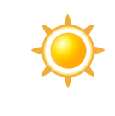

****************************************************************
****************************************************************
Toronto ,  2013-02-10 00:00:00
*******************************
Temperature:     -7.57 C
Pressure:        102.1 kPa
Humidity:        87.8 %
Wind Speed:      7.77 m/s
Wind Direction:  SW
Feels Like:      -16.0  C

Weather Forcast:
Mostly Rainy
Probability of Precipitation (PoP):  % 72


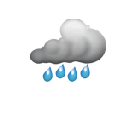

****************************************************************
****************************************************************
Toronto ,  2013-02-11 00:00:00
*******************************
Temperature:     -6.38 C
Pressure:        102.67 kPa
Humidity:        79.79 %
Wind Speed:      4.91 m/s
Wind Direction:  SW
Feels Like:      -13.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 27


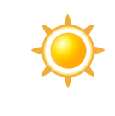

In [16]:
code=34
days=pd.date_range(start='2013-02-01', end='2013-02-11',dtype='datetime64[ns]', freq='D')

for today in days:                   
    get_predictions(today,code)


In the following cell, for all cities for a sample day (July 24th, 2015) predictions/descriptions are shown:


****************************************************************
****************************************************************
Albuquerque ,  2015-7-24
*******************************
Temperature:     23.39 C
Pressure:        101.92 kPa
Humidity:        42.96 %
Wind Speed:      2.55 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Foggy
Partly Sunny
Probability of Precipitation (PoP):  % 6


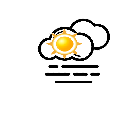

****************************************************************
****************************************************************
Atlanta ,  2015-7-24
*******************************
Temperature:     25.09 C
Pressure:        101.48 kPa
Humidity:        78.94 %
Wind Speed:      2.01 m/s
Wind Direction:  SE

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 5


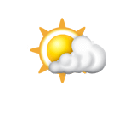

****************************************************************
****************************************************************
Beersheba ,  2015-7-24
*******************************
Temperature:     26.44 C
Pressure:        98.76 kPa
Humidity:        52.23 %
Wind Speed:      1.87 m/s
Wind Direction:  W

Weather Forcast:
Mostly Cloudy
Partly Sunny
Probability of Precipitation (PoP):  % 3


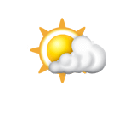

****************************************************************
****************************************************************
Boston ,  2015-7-24
*******************************
Temperature:     21.94 C
Pressure:        101.3 kPa
Humidity:        73.87 %
Wind Speed:      2.6 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 5


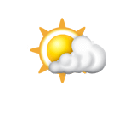

****************************************************************
****************************************************************
Charlotte ,  2015-7-24
*******************************
Temperature:     26.35 C
Pressure:        101.33 kPa
Humidity:        70.65 %
Wind Speed:      1.95 m/s
Wind Direction:  SE

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 5


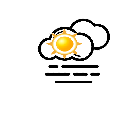

****************************************************************
****************************************************************
Chicago ,  2015-7-24
*******************************
Temperature:     23.09 C
Pressure:        101.48 kPa
Humidity:        56.99 %
Wind Speed:      2.33 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Foggy
Partly Sunny
Probability of Precipitation (PoP):  % 5


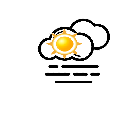

****************************************************************
****************************************************************
Dallas ,  2015-7-24
*******************************
Temperature:     30.46 C
Pressure:        101.43 kPa
Humidity:        52.82 %
Wind Speed:      3.55 m/s
Wind Direction:  SW
Feels Like:      32.0  C

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 8


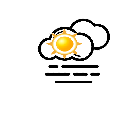

****************************************************************
****************************************************************
Denver ,  2015-7-24
*******************************
Temperature:     23.75 C
Pressure:        101.79 kPa
Humidity:        37.41 %
Wind Speed:      2.48 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Foggy
Partly Sunny
Probability of Precipitation (PoP):  % 6


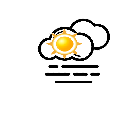

****************************************************************
****************************************************************
Detroit ,  2015-7-24
*******************************
Temperature:     22.43 C
Pressure:        101.45 kPa
Humidity:        58.4 %
Wind Speed:      2.24 m/s
Wind Direction:  SE

Weather Forcast:
Mostly Cloudy
Partly Sunny
Probability of Precipitation (PoP):  % 4


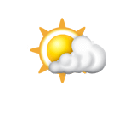

****************************************************************
****************************************************************
Eilat ,  2015-7-24
*******************************
Temperature:     33.67 C
Pressure:        99.75 kPa
Humidity:        35.62 %
Wind Speed:      3.27 m/s
Wind Direction:  SW
Feels Like:      34.0  C

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 3


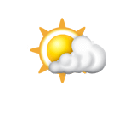

****************************************************************
****************************************************************
Haifa ,  2015-7-24
*******************************
Temperature:     32.76 C
Pressure:        100.64 kPa
Humidity:        75.04 %
Wind Speed:      2.29 m/s
Wind Direction:  SW
Feels Like:      45.0  C

Weather Forcast:
Mostly Cloudy
Partly Sunny
Probability of Precipitation (PoP):  % 2


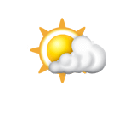

****************************************************************
****************************************************************
Houston ,  2015-7-24
*******************************
Temperature:     28.91 C
Pressure:        101.66 kPa
Humidity:        69.86 %
Wind Speed:      3.33 m/s
Wind Direction:  SW
Feels Like:      33.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 7


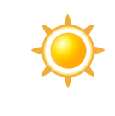

****************************************************************
****************************************************************
Indianapolis ,  2015-7-24
*******************************
Temperature:     23.15 C
Pressure:        101.48 kPa
Humidity:        58.64 %
Wind Speed:      2.23 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Foggy
Partly Sunny
Probability of Precipitation (PoP):  % 6


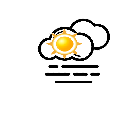

****************************************************************
****************************************************************
Jacksonville ,  2015-7-24
*******************************
Temperature:     28.59 C
Pressure:        101.56 kPa
Humidity:        65.84 %
Wind Speed:      3.0 m/s
Wind Direction:  SW
Feels Like:      31.0  C

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 6


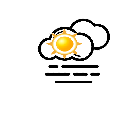

****************************************************************
****************************************************************
Jerusalem ,  2015-7-24
*******************************
Temperature:     29.22 C
Pressure:        100.7 kPa
Humidity:        59.29 %
Wind Speed:      2.55 m/s
Wind Direction:  SW
Feels Like:      31.0  C

Weather Forcast:
Mostly Cloudy
Partly Sunny
Probability of Precipitation (PoP):  % 3


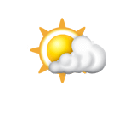

****************************************************************
****************************************************************
Kansas City ,  2015-7-24
*******************************
Temperature:     25.0 C
Pressure:        101.36 kPa
Humidity:        73.37 %
Wind Speed:      2.73 m/s
Wind Direction:  SE

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 6


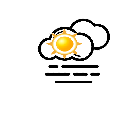

****************************************************************
****************************************************************
Las Vegas ,  2015-7-24
*******************************
Temperature:     29.52 C
Pressure:        101.26 kPa
Humidity:        29.31 %
Wind Speed:      3.93 m/s
Wind Direction:  SW
Feels Like:      28.0  C

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 8


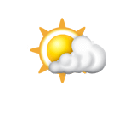

****************************************************************
****************************************************************
Los Angeles ,  2015-7-24
*******************************
Temperature:     23.42 C
Pressure:        101.45 kPa
Humidity:        71.85 %
Wind Speed:      2.42 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Foggy
Partly Sunny
Probability of Precipitation (PoP):  % 5


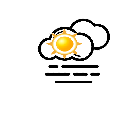

****************************************************************
****************************************************************
Miami ,  2015-7-24
*******************************
Temperature:     29.39 C
Pressure:        101.74 kPa
Humidity:        70.16 %
Wind Speed:      2.44 m/s
Wind Direction:  SW
Feels Like:      34.0  C

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 5


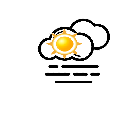

****************************************************************
****************************************************************
Minneapolis ,  2015-7-24
*******************************
Temperature:     22.39 C
Pressure:        101.4 kPa
Humidity:        66.87 %
Wind Speed:      2.43 m/s
Wind Direction:  SE

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 5


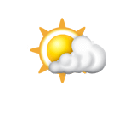

****************************************************************
****************************************************************
Montreal ,  2015-7-24
*******************************
Temperature:     19.43 C
Pressure:        101.11 kPa
Humidity:        66.03 %
Wind Speed:      3.48 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 7


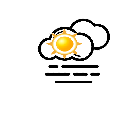

****************************************************************
****************************************************************
Nahariyya ,  2015-7-24
*******************************
Temperature:     29.06 C
Pressure:        101.13 kPa
Humidity:        76.25 %
Wind Speed:      2.28 m/s
Wind Direction:  W
Feels Like:      34.0  C

Weather Forcast:
Mostly Cloudy
Partly Sunny
Probability of Precipitation (PoP):  % 2


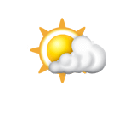

****************************************************************
****************************************************************
Nashville ,  2015-7-24
*******************************
Temperature:     25.05 C
Pressure:        101.45 kPa
Humidity:        84.87 %
Wind Speed:      1.79 m/s
Wind Direction:  SE

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 8


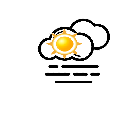

****************************************************************
****************************************************************
New York ,  2015-7-24
*******************************
Temperature:     23.4 C
Pressure:        101.22 kPa
Humidity:        61.8 %
Wind Speed:      2.72 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 5


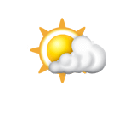

****************************************************************
****************************************************************
Philadelphia ,  2015-7-24
*******************************
Temperature:     22.2 C
Pressure:        101.36 kPa
Humidity:        53.2 %
Wind Speed:      2.53 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 6


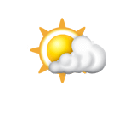

****************************************************************
****************************************************************
Phoenix ,  2015-7-24
*******************************
Temperature:     32.83 C
Pressure:        101.09 kPa
Humidity:        27.9 %
Wind Speed:      2.54 m/s
Wind Direction:  SW
Feels Like:      32.0  C

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 6


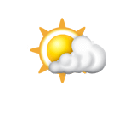

****************************************************************
****************************************************************
Pittsburgh ,  2015-7-24
*******************************
Temperature:     20.82 C
Pressure:        101.56 kPa
Humidity:        68.31 %
Wind Speed:      1.7 m/s
Wind Direction:  SE

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 5


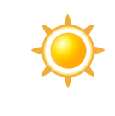

****************************************************************
****************************************************************
Portland ,  2015-7-24
*******************************
Temperature:     19.05 C
Pressure:        101.39 kPa
Humidity:        63.18 %
Wind Speed:      2.67 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Foggy
Partly Sunny
Probability of Precipitation (PoP):  % 6


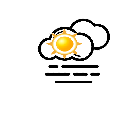

****************************************************************
****************************************************************
Saint Louis ,  2015-7-24
*******************************
Temperature:     25.62 C
Pressure:        101.42 kPa
Humidity:        59.91 %
Wind Speed:      2.31 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Foggy
Partly Sunny
Probability of Precipitation (PoP):  % 6


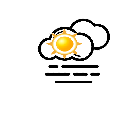

****************************************************************
****************************************************************
San Antonio ,  2015-7-24
*******************************
Temperature:     29.08 C
Pressure:        101.59 kPa
Humidity:        63.46 %
Wind Speed:      3.27 m/s
Wind Direction:  SW
Feels Like:      32.0  C

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 8


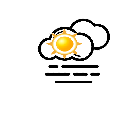

****************************************************************
****************************************************************
San Diego ,  2015-7-24
*******************************
Temperature:     23.44 C
Pressure:        101.48 kPa
Humidity:        69.92 %
Wind Speed:      2.56 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Foggy
Partly Sunny
Probability of Precipitation (PoP):  % 5


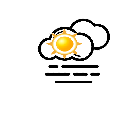

****************************************************************
****************************************************************
San Francisco ,  2015-7-24
*******************************
Temperature:     18.27 C
Pressure:        101.53 kPa
Humidity:        75.17 %
Wind Speed:      3.4 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Sunny
Partly Foggy
Probability of Precipitation (PoP):  % 6


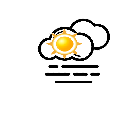

****************************************************************
****************************************************************
Seattle ,  2015-7-24
*******************************
Temperature:     18.65 C
Pressure:        101.39 kPa
Humidity:        68.55 %
Wind Speed:      2.04 m/s
Wind Direction:  SE

Weather Forcast:
Mostly Cloudy
Partly Sunny
Probability of Precipitation (PoP):  % 5


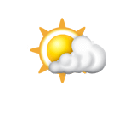

****************************************************************
****************************************************************
Tel Aviv District ,  2015-7-24
*******************************
Temperature:     29.42 C
Pressure:        100.7 kPa
Humidity:        72.05 %
Wind Speed:      2.75 m/s
Wind Direction:  SW
Feels Like:      34.0  C

Weather Forcast:
Mostly Cloudy
Partly Sunny
Probability of Precipitation (PoP):  % 3


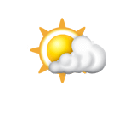

****************************************************************
****************************************************************
Toronto ,  2015-7-24
*******************************
Temperature:     20.79 C
Pressure:        101.31 kPa
Humidity:        55.95 %
Wind Speed:      3.42 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 7


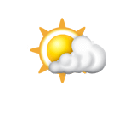

****************************************************************
****************************************************************
Vancouver ,  2015-7-24
*******************************
Temperature:     18.78 C
Pressure:        101.19 kPa
Humidity:        69.42 %
Wind Speed:      2.72 m/s
Wind Direction:  SW

Weather Forcast:
Mostly Sunny
Partly Cloudy
Probability of Precipitation (PoP):  % 5


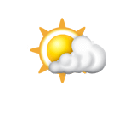

In [17]:
today='2015-7-24'

for code in range(0,36):                 
    get_predictions(today,code)


The following cell takes the name of the city and the date from a user and then prints out the prediction for that date: 

Enter a city: Chicago
Enter a date between October 2012 and October 2017(format: yyyy-mm-dd: ): 2015-02-02
****************************************************************
****************************************************************
Chicago ,  2015-02-02
*******************************
Temperature:     -2.71 C
Pressure:        103.34 kPa
Humidity:        95.16 %
Wind Speed:      5.17 m/s
Wind Direction:  SW
Feels Like:      -8.0  C

Weather Forcast:
Mostly Sunny
Probability of Precipitation (PoP):  % 17


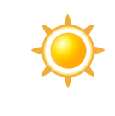

In [23]:
## user cell
city = input('Enter a city: ')
today = input('Enter a date between October 2012 and October 2017(format: yyyy-mm-dd): ')

city_list=list(cities)
code=city_list.index(city) 

get_predictions(today,code)

###   Appendix


In the following cells, some other code lines are introduced that can help us explore and understand the data better.

The next cell prints out the name of all cities and their indices:

In [24]:
cities

0           Albuquerque
1               Atlanta
2             Beersheba
3                Boston
4             Charlotte
5               Chicago
6                Dallas
7                Denver
8               Detroit
9                 Eilat
10                Haifa
11              Houston
12         Indianapolis
13         Jacksonville
14            Jerusalem
15          Kansas City
16            Las Vegas
17          Los Angeles
18                Miami
19          Minneapolis
20             Montreal
21            Nahariyya
22            Nashville
23             New York
24         Philadelphia
25              Phoenix
26           Pittsburgh
27             Portland
28          Saint Louis
29          San Antonio
30            San Diego
31        San Francisco
32              Seattle
33    Tel Aviv District
34              Toronto
35            Vancouver
Name: City, dtype: object

The next cells plot the number of status of each day for a given city. 

For example, here we can see that for the past 5 years most days in New York were cloudy. While LA had more than 1000 sunny days (out of 1852 total days)

Total days: 1852


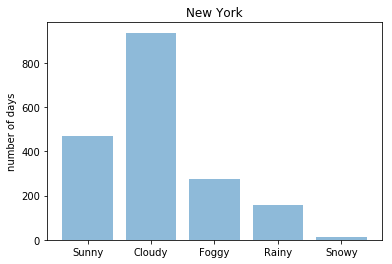

In [25]:
### looking at status for each city 
code=23
df_status=df_city[code].groupby(['status']).count()
city_status=df_status.iloc[:,1];
range_limit=city_status.shape[0]
bins=list(0 for i in range(0,range_limit)) 
for i in range(0,range_limit):
    bins[i]=description[i]
plt.rcParams['figure.figsize']=(6,4)
plt.title(cities[code])
plt.bar( bins,city_status, alpha=0.5, label='x');
plt.ylabel('number of days');
print('Total days:',df_city[code].shape[0])

Total days: 1852


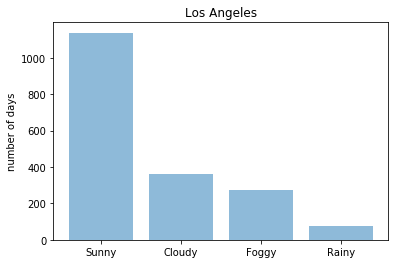

In [26]:
code=17
df_status=df_city[code].groupby(['status']).count()
city_status=df_status.iloc[:,1];
range_limit=city_status.shape[0]
bins=list(0 for i in range(0,range_limit)) 
for i in range(0,range_limit):
    bins[i]=description[i]
plt.rcParams['figure.figsize']=(6,4)
plt.title(cities[code])
plt.bar( bins,city_status, alpha=0.5, label='x');
plt.ylabel('number of days');
print('Total days:',df_city[code].shape[0])

The next cell helps us see where the classes are scattered based on different features.
In this example, for city of Boston, looking at temperature and humidity we can see where all the cloudy and snowy days are scattered.  

Boston


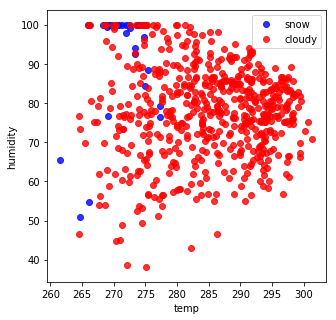

In [27]:
### plotting scatter plots to see where classes are
code=3
df_show=df_city[code]
print(cities[code])
df_storm=df_show[df_show['status']==5]
df_snow=df_show[df_show['status']==4]
df_rain=df_show[df_show['status']==3]
df_fog=df_show[df_show['status']==2]
df_cloudy=df_show[df_show['status']==1]
df_clear=df_show[df_show['status']==0]
var1='temp'
var2='humidity'
plt.rcParams['figure.figsize']=(5,5)
# plt.scatter(df_storm[var1], df_storm[var2],  c='black',label='storm');
plt.scatter(df_snow[var1], df_snow[var2],  c='blue',label='snow',alpha=0.8);
# plt.scatter(df_rain[var1], df_rain[var2],  c='green',label='rain',alpha=0.3);
# plt.scatter(df_fog[var1], df_fog[var2],  c='brown',label='fog',alpha=0.3);
plt.scatter(df_cloudy[var1], df_cloudy[var2],  c='red',label='cloudy',alpha=0.8);
# plt.scatter(df_clear[var1], df_clear[var2],  c='orange',label='clear',alpha=0.3);
plt.xlabel(var1);
plt.ylabel(var2);
plt.legend();

In the next plot, for the city of Nashville we can see the clusters of rainy and sunny days on the 2-D graph of temperature and humidity. 

Nashville


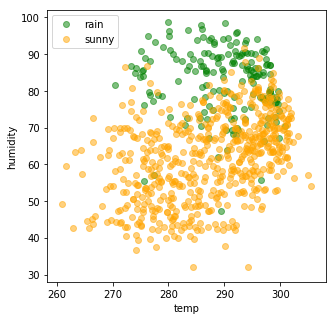

In [28]:
code=22
df_show=df_city[code]
print(cities[code])
df_storm=df_show[df_show['status']==5]
df_snow=df_show[df_show['status']==4]
df_rain=df_show[df_show['status']==3]
df_fog=df_show[df_show['status']==2]
df_cloudy=df_show[df_show['status']==1]
df_clear=df_show[df_show['status']==0]
var1='temp'
var2='humidity'
plt.rcParams['figure.figsize']=(5,5)
# plt.scatter(df_storm[var1], df_storm[var2],  c='red',label='storm');
# plt.scatter(df_snow[var1], df_snow[var2],  c='blue',label='snow',alpha=0.8);
plt.scatter(df_rain[var1], df_rain[var2],  c='green',label='rain',alpha=0.5);
# plt.scatter(df_fog[var1], df_fog[var2],  c='brown',label='fog',alpha=0.3);
# plt.scatter(df_cloudy[var1], df_cloudy[var2],  c='black',label='cloudy',alpha=0.8);
plt.scatter(df_clear[var1], df_clear[var2],  c='orange',label='sunny',alpha=0.5);
plt.xlabel(var1);
plt.ylabel(var2);
plt.legend();

In the next following cells, we can look at temperature, humidity and wind for different cities and compare them against one another:

As seen below, temperature in Toronto has a bigger range compared to Miami. We can also  see that Seattle is more humid than Las Vegas. At the end we can see that Chicago is windier compared to LA. Also for Chicago, winters are windier than summer time.

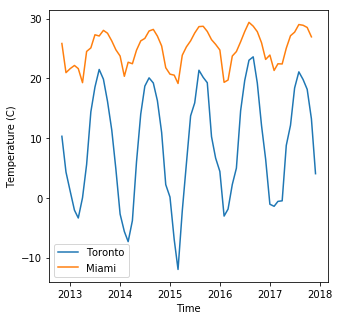

In [29]:
df_show=pd.DataFrame(df_temp.resample('M').mean())
plt.rcParams['figure.figsize']=(5,5)
plt.plot((df_show['Toronto'])-273.15);
plt.plot((df_show['Miami'])-273.15);
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend();

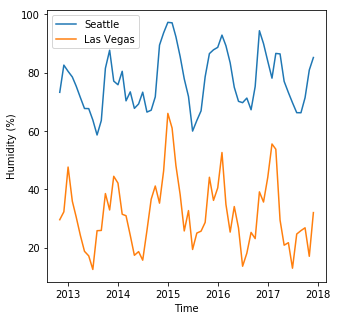

In [30]:
df_show=pd.DataFrame(df_humidity.resample('M').mean())
plt.rcParams['figure.figsize']=(5,5)
plt.plot((df_show['Seattle']));
plt.plot((df_show['Las Vegas']));
plt.xlabel('Time')
plt.ylabel('Humidity (%)')
plt.legend();

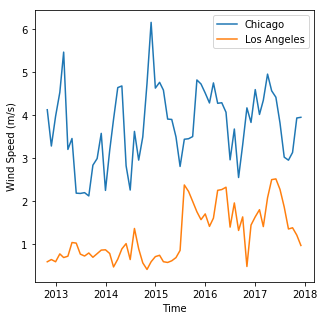

In [31]:
df_show=pd.DataFrame(df_wind.resample('M').mean())
plt.rcParams['figure.figsize']=(5,5)
plt.plot((df_show['Chicago']));
plt.plot((df_show['Los Angeles']));
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.legend();

### Hyper-parameter optimization for XGBoost


In the next cell, we will look at hyper-parameter (max_depth) for XGBoost, depending on the test train split we either get 5 or 7 as optimum answer.


In [ ]:
#### hyper-parameter optimization for xgboost
xs=['temp_1','temp_2','pressure_1','pressure_2','humidity_1','humidity_2','wind_1' 
    ,'wind_2' , 'status_1', 'status_2','wind_dir_1','wind_dir_2','Longitude','Latitude',
    'Elevation' ,'month','by_the_water','season',
    'temp','pressure', 'humidity']

x = df_concat[xs].values
y = df_concat['status'].values

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,train_size=0.2,stratify=y)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

validation_score_list = []
depth_range = np.arange(1,15)

for i in depth_range:
    XGB_status = XGBClassifier(max_depth=i,booster='gbtree')
    XGB_status.fit(x_train,y_train)
    validation_score = np.mean(cross_val_score(XGB_status, x_test,y_test, cv = 5))
    validation_score_list.append(validation_score)

plt.rcParams['figure.figsize']=(5,5)
plt.scatter(depth_range, validation_score_list,label="Validation Score")
plt.legend();
plt.xlabel('Depth');
plt.ylabel('Score');
plt.show();
print("Best Model: Depth: ", validation_score_list.index(np.max(validation_score_list))+1)
print('Accuracy: ',np.max(validation_score_list))

Next cell, we will use statsmodels time-series analysis to look at temperature of Toronto and break it down into different components such as overall trend and residuals

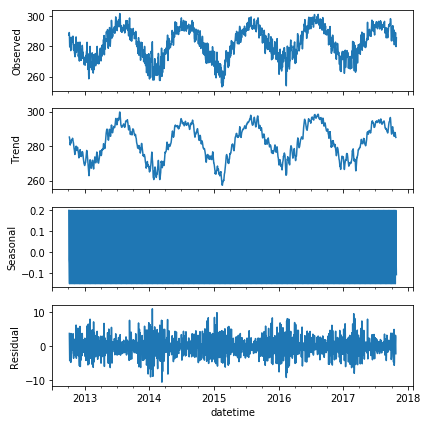

In [32]:
code=34
var2='temp'
result = seasonal_decompose(df_city[code][var2])
plt.rcParams['figure.figsize']=(6,6)
result.plot()
pyplot.show()

### Conclusion

The goal of this project was to predict the weather for a given city based on the data of last two days. 

In overall, the model performed well for continuous variables specially temperature, while other features such as wind speed proved more difficult to predict.
With more features and data points from surrounding areas for each city the results can be improved.

For future work, it is suggested that the model will use data on amount of precipitation, amount of water vapor in atmosphere or pressure difference between a city and the areas around it, so it could provide better predictions for the user.

Also the user cell, can be developed into a nice interactive website where the user would type in the name of a city and the code with scrap the data of past two days from weather websites and then print out its prediction for today. 

